**Google Colab: https://colab.research.google.com/drive/14HT92t-JPtizQEI4Boalr8cmBn0j8-cK?usp=sharing**

In [35]:
%pip install numpy keras matplotlib tqdm pickle-mixin

Note: you may need to restart the kernel to use updated packages.


In [36]:
from numpy.typing import NDArray
from typing import Dict
import numpy as np
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

**Data**

It is important to note that in this implementation, different examples are in different columns.

In [37]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")

x_train = np.reshape(x_train, (x_train.shape[0], -1))
m = x_train.shape[0]

x_test = np.reshape(x_test, (x_test.shape[0], -1))
m_t = x_test.shape[0]

def one_hot_encoding(size, Y):
    ny = np.zeros(size)
    for i in range(size[0]):
        ny[i, Y[i]] = 1
    return ny

y_train_encoded = (one_hot_encoding((m, 10), y_train)).T
y_test = (y_test.reshape(1, -1))
x_train = x_train.T
x_test = x_test.T

**Neural Network Implementation**

This implementation assumes that no Softmax layer will be used outside the output layer.

In [38]:
class Scalar:

    @staticmethod
    def z_score(data: NDArray[np.float64]) -> NDArray[np.float64]:
        mean: int = np.mean(data, axis=0)
        std: int = np.std(data, axis=0)
        std[std == 0] = 1
        return (data - mean) / std

In [39]:
class Layer:
    __supported_activations: list[str] = ["linear","relu","softmax"]

    def __init__(self, size: int, activation: str = "linear") -> None:
        if activation not in Layer.__supported_activations:
            raise ValueError(f"Parameter 'activation' not supported, please enter one of the following: {', '.join(Layer.__supported_activations)}")
        self.__size: int = size
        self.__activation: str = activation
        self.__parent: Layer = None
        self.__child: Layer = None
        self.__W: NDArray[np.float64] = None
        self.__B: NDArray[np.float64] = None
        self.__A: NDArray[np.float64] = None
        self.__dZ: NDArray[np.float64] = None

    def __str__(self) -> str:
        return f"ID: {self.__id} | Neurons: {self.__size} | Activation: {self.__activation}"

    def set_parent(self, parent: "Layer") -> None:
        self.__parent = parent

    def get_parent(self) -> "Layer":
        return self.__parent

    def set_child(self, child: "Layer") -> None:
        self.__child = child

    def get_child(self) -> "Layer":
        return self.__child

    def set_id(self, id: int) -> None:
        self.__id = id

    def get_id(self) -> int:
        return self.__id

    def get_size(self) -> int:
        return self.__size

    def get_activation(self) -> str:
        return self.__activation
    
    def get_dz(self) -> NDArray[np.float64]:
        return self.__dZ

    def set_dz(self, dZ: NDArray[np.float64]) -> None:
        self.__dZ: NDArray[np.float64] = dZ

    # New layers
    def set_neurons(self) -> None:
        if self.__parent:
            parent_size: int = self.__parent.get_size()
            self.__W: NDArray[np.float64] = np.random.normal(0, 0.05, size=(self.__size, parent_size))
            self.__B: NDArray[np.float64] = np.zeros((self.__size, 1))
            self.__A: NDArray[np.float64] = np.zeros((self.__size, 1))

    def get_value(self) -> NDArray[np.float64]:
        return self.__A
    
    def get_parameters(self) -> list[NDArray[np.float64]]:
        return self.__W, self.__B
    
    def set_parameters(self, W: NDArray[np.float64], B: NDArray[np.float64]) -> None:
        self.__W = W
        self.__B = B
    
    def update_parameters(self, learning_rate: float, dW: NDArray[np.float64], dB: NDArray[np.float64]):
        self.__W -= learning_rate * dW
        self.__B -= learning_rate * dB

    def set_input(self, input: NDArray[np.float64]) -> None:
        self.__A  = input

    def activation_function(self, Z: NDArray[np.float64]) -> NDArray[np.float64]:
        if self.__activation == "relu":
            return np.maximum(Z, 0)
        elif self.__activation == "softmax":
            exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
            return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
        else:
            return Z

    def forward(self) -> None:
        if self.__parent:
            Z = np.matmul(self.__W, self.__parent.get_value()) + self.__B
            self.__A = self.activation_function(Z)


In [40]:
class Loss:
    __supported_losses: list[str] = ["CCEL"]
    __supported_regularizations: list[str] = ["none", "L2"]

    def __init__(self, loss: str = "CCEL", learning_rate: float = 1e-4, regularization: str = "none", lambda_: float = 0.01, batch_size: int = 32) -> None:
        if loss not in Loss.__supported_losses:
            raise ValueError(f"Parameter 'loss' not supported, please enter one of the following: {', '.join(Loss.__supported_losses)}")
        if regularization not in Loss.__supported_regularizations:
            raise ValueError(f"Parameter 'regularization' not supported, please enter one of the following: {', '.join(Loss.__supported_regularizations)}")
        
        self.__loss: str = loss
        self.__learning_rate: float = learning_rate
        self.__regularization: str = regularization
        self.__lambda: float = lambda_
        self.__batch_size: int = batch_size
    
    def get_loss(self) -> str:
        return self.__loss
    
    def get_learning_rate(self) -> float:
        return self.__learning_rate
    
    def get_regularization(self) -> str:
        return self.__regularization
    
    def get_lambda(self) -> float:
        return self.__lambda
    
    def get_batch_size(self) -> int:
        return self.__batch_size

    def loss_computation(self, layers: list[Layer], y_batch: NDArray[np.float64]) -> float:
        output_layer: Layer = layers[-1]
        predictions: NDArray[np.float64] = output_layer.get_value()
        
        # Categorical Cross-Entropy Loss Computation
        if self.__loss == "CCEL":
            batch_size = y_batch.shape[1]
            loss: float = -np.sum(y_batch * np.log(predictions + 1e-9)) / batch_size
        
        # L2 Regularization
        if self.__regularization == "L2":
            reg_loss = 0.5 * self.__lambda * sum(np.sum(layer.get_parameters()[0] ** 2) 
                                                 for layer in layers if layer.get_parameters()[0] is not None)
            loss += reg_loss / batch_size

        return loss

In [41]:
class NeuralNetwork:

    def __init__(self) -> None:
        self.__layers: list[Layer] = []

    def __str__(self) -> str:
        layers_str = "\n".join(f"\t{layer}" for layer in self.__layers)
        return f"Neural Network:\n{layers_str}\nTotal of Parameters: {self.get_num_of_parameters()}"
    
    def get_num_of_parameters(self) -> int:
        num: int = 0
        for layer in self.__layers:
            W, B = layer.get_parameters()
            if W is not None and B is not None:
                num += W.shape[0] * W.shape[1] + B.shape[0]
        return num

    # Hidden layers can only be linear or ReLU
    def build(self, layers: list[Layer]) -> None:
        self.__layers: list[Layer] = layers
        # Updating layers' relationships
        layers[0].set_id(0)
        for i in range(1, len(layers)):
            layers[i].set_parent(layers[i - 1])
            layers[i - 1].set_child(layers[i])
            layers[i].set_neurons()
            layers[i].set_id(i)

    def fit_data(self, train: tuple[NDArray[np.float64]], test: tuple[NDArray[np.float64]]) -> None:
        input, target = train
        test_input, test_target = test
        # An input with P features and Q examples should have the shape (P,Q)
        # A target should have the shape (K,Q)
        if input.shape[0] != self.__layers[0].get_size():
            raise ValueError(f"At the input layer, supported size is: ({self.__layers[0].get_size()},n?), received: {input.shape}")
        if target.shape[0] != self.__layers[-1].get_size():
            raise ValueError(f"At the target layer, supported size is: ({self.__layers[-1].get_size()},n?), received: {target.shape}")
        
        self.__input: NDArray[np.float64] = input
        self.__target: NDArray[np.float64] = target
        self.__test_input: NDArray[np.float64] = test_input
        self.__test_target: NDArray[np.float64] = test_target
        
        # Creating weight matrix W, bias vector B, and value vector A for every layer
        # For a specifc layer containing K neurons, having a parent layer containing N neurons:
        # W shape: (K,N) | B shape: (K,1) | A shape: (K,1)
        for layer in self.__layers:
            layer.set_neurons()

    def forward_propagation(self, x_batch: NDArray[np.float64]) -> None:
        self.__layers[0].set_input(x_batch)
        for layer in self.__layers[1:]:
            layer.forward()

    def back_propagation(self, y_batch: NDArray[np.float64]) -> None:
        if self.__loss.get_loss() == "CCEL":
            # Output layer gradient for CCEL with Softmax
            output_layer = self.__layers[-1]
            output_layer.set_dz(output_layer.get_value() - y_batch)

            # Backpropagate through hidden layers
            for i in range(len(self.__layers) - 2, -1, -1):
                layer: Layer = self.__layers[i]
                child_layer: Layer = self.__layers[i + 1]

                # dA (Gradient of loss with respect to layer's activations)
                dA: NDArray[np.float64] = np.matmul(child_layer.get_parameters()[0].T, child_layer.get_dz())

                if layer.get_activation() == "relu":
                    dZ: NDArray[np.float64] = dA * (layer.get_value() > 0)
                else:
                    dZ: NDArray[np.float64] = dA
                
                layer.set_dz(dZ)
        
            # Updating parameters
            learning_rate: float = self.__loss.get_learning_rate()
            for layer in self.__layers[1:]:
                dW: NDArray[np.float64] = np.matmul(layer.get_dz(), layer.get_parent().get_value().T) / y_batch.shape[1]
                dB: NDArray[np.float64] = np.sum(layer.get_dz(), axis=1, keepdims=True) / y_batch.shape[1]

                if self.__loss.get_regularization() == "L2":
                    dW += self.__loss.get_lambda() * layer.get_parameters()[0]

                layer.update_parameters(learning_rate, dW, dB)

    def train(self, epochs: int, loss: Loss = Loss()) -> tuple[list[float]]:
        self.__loss: Loss = loss
        batch_size = self.__loss.get_batch_size()
        loss_hist: list[float] = []
        test_accuracy: list[float] = []
        num_samples = self.__input.shape[1]
        
        for epoch in tqdm(range(epochs), leave=True, position=0):
            indices = np.random.permutation(num_samples)  # Shuffle dataset
            for batch_start in range(0, num_samples, batch_size):
                batch_indices = indices[batch_start:batch_start + batch_size]
                x_batch = self.__input[:, batch_indices]
                y_batch = self.__target[:, batch_indices]
                
                self.forward_propagation(x_batch)
                self.back_propagation(y_batch)
                loss_hist.append(self.__loss.loss_computation(self.__layers, y_batch))
                test_accuracy.append(self.test(self.__test_input, self.__test_target))
        
        return (loss_hist, test_accuracy)

    def get_results(self) -> NDArray[np.float64]:
        return self.__layers[-1].get_value()
    
    def get_parameters(self) -> Dict[int, list[NDArray[np.float64]]]:
      parameters = {}
      for i, layer in enumerate(self.__layers):
          parameters[i] = layer.get_parameters()
      return parameters

    def set_nn_parameters(self, parameters: Dict[int, list[NDArray[np.float64]]]) -> None:
      for i, (W, B) in parameters.items():
          self.__layers[i].set_parameters(W, B)

    def test(self, test_input: NDArray[np.float64], test_target: NDArray[np.float64]) -> float:
        test_predictions: NDArray[np.int64] = self.predict(test_input)  # Shape: (1, m)
        if test_target.shape[0] > 1:  # If shape is (10, m), convert it
            test_target = np.argmax(test_target, axis=0).reshape(1, -1)  # Shape: (1, m)
        correct_predictions: int = np.sum(test_predictions == test_target)
        total_samples: int = test_target.shape[1]
        accuracy: float = correct_predictions / total_samples
        return accuracy


    def predict(self, input: NDArray[np.float64]) -> NDArray[np.int64]:
        self.__layers[0].set_input(input)
        for layer in self.__layers[1:]:
            layer.forward()
        probabilities: NDArray[np.float64] = self.get_results()
        predictions: NDArray[np.int64] = np.argmax(probabilities, axis=0).reshape(1, -1)
        return predictions

**Defining the neural network**

To load predefined weights, use the `set_nn_parameters()` from the `NeuralNetwork` class.

In [42]:
model = NeuralNetwork()
model.build([
    Layer(784),
    Layer(128, "relu"),
    Layer(128, "relu"),
    Layer(10, "softmax")
])

scaled_x = Scalar().z_score(x_train)
scaled_x_test = Scalar().z_score(x_test)
model.fit_data((scaled_x, y_train_encoded), (scaled_x_test, y_test))

with open('nn_parameters.pkl', 'rb') as f:
    parameters: Dict[int, list[NDArray[np.float64]]] = pickle.load(f)
model.set_nn_parameters(parameters)

print(model)

Neural Network:
	ID: 0 | Neurons: 784 | Activation: linear
	ID: 1 | Neurons: 128 | Activation: relu
	ID: 2 | Neurons: 128 | Activation: relu
	ID: 3 | Neurons: 10 | Activation: softmax
Total of Parameters: 118282


**Training the neural network**

In [43]:
epochs = 0
loss_hist = []
test_accuracy_hist = []

with open('nn_hist.pkl', 'rb') as f:
    imported_loss_hist, imported_test_accuracy_hist = pickle.load(f)
loss_hist += imported_loss_hist
test_accuracy_hist += imported_test_accuracy_hist


epochs_loss_hist, epochs_test_accuracy_hist = model.train(epochs, Loss(learning_rate=5e-2, regularization="L2", lambda_=1e-3, batch_size=60000))

loss_hist += epochs_loss_hist
test_accuracy_hist += epochs_test_accuracy_hist

0it [00:00, ?it/s]


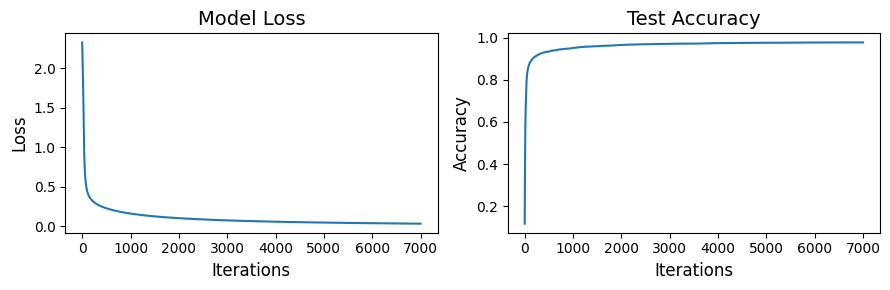

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

# Loss plot (log scale)
ax[0].plot(range(len(loss_hist)), loss_hist)
ax[0].set_xlabel("Iterations", fontsize=12)
ax[0].set_ylabel("Loss", fontsize=12)
ax[0].set_title("Model Loss", fontsize=14)

# Test accuracy plot
ax[1].plot(range(len(test_accuracy_hist)), test_accuracy_hist)
ax[1].set_xlabel("Iterations", fontsize=12)
ax[1].set_ylabel("Accuracy", fontsize=12)
ax[1].set_title("Test Accuracy", fontsize=14)

fig.tight_layout()
plt.show()

**Testing the model**

In [45]:
accuracy = model.test(scaled_x_test, y_test)
print(f"Model's accuracy: {(accuracy * 100):.2f}%")

Model's accuracy: 97.76%


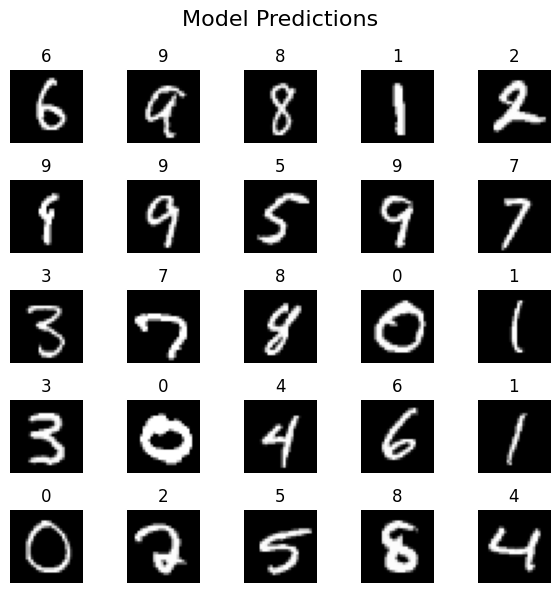

In [46]:
rows = 5
cols = 5
start_point = 3000

examples = x_test[:,start_point:start_point+rows*cols].T
predicitions = model.predict(x_test[:,start_point:start_point+rows*cols]).reshape(-1,)

fig, ax = plt.subplots(rows, cols, figsize=(6, 6))
plt.suptitle("Model Predictions", fontsize=16)
for i, img in enumerate(examples):
  ax.ravel()[i].imshow(np.reshape(img, (28,28)), cmap=plt.get_cmap('gray'))
  ax.ravel()[i].set_title(predicitions[i])
  ax.ravel()[i].axis("off")

plt.tight_layout()
plt.show()

**Saving the neural network parameters**

In [47]:
with open('nn_parameters.pkl', 'wb') as f:
   pickle.dump(model.get_parameters(), f)

**Saving the history**

In [48]:
with open('nn_hist.pkl', 'wb') as f:
    pickle.dump((loss_hist, test_accuracy_hist), f)   